In [1]:
import numpy as np
from matplotlib import pyplot as plt
import libs.MEVeS as S
import libs.AtomicConstants.Atom as A
import libs.Optimiser as Opt

In [2]:
pi_unicode = "\u03C0"
times_unicode = "\u00D7"

# Standard EIT

## OD = 1500 (standard OD = 3000)

### Test control initial condition 

In [3]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n": 6, "L":0, "F" : 3}}}
atom = A.Cs(config)

In [4]:
T = 0 # temperature of the ensemble in K
vno = 1 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = 1500

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

In [13]:
### Make solver class
protocol = 'EIT'
tau = 330e-12*np.sqrt(2)
m = 800
detuning = 0

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 4*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

tr = 2*t0 # storage time

Omega_store = 5e9
Omega_retrieve = 1e10
Control_tp = (S.gaussian(t, t0, tau, Omega_store) + S.gaussian(t, t0+tr, tau, Omega_retrieve))[:, None] * control_pol[None, :] # control field

Control_tzp = sol.co_prop( Control_tp )
sol.solve(Control_tzp, method='RK4-Ralston')

storage = sol.storage_efficiency(sol.S, mi=m//2) # half way through simulation
retrieved = sol.retrieval_efficiency(sol.E, m//2, 0)

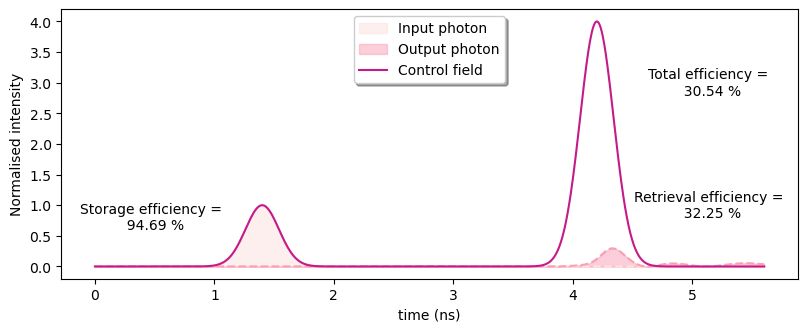

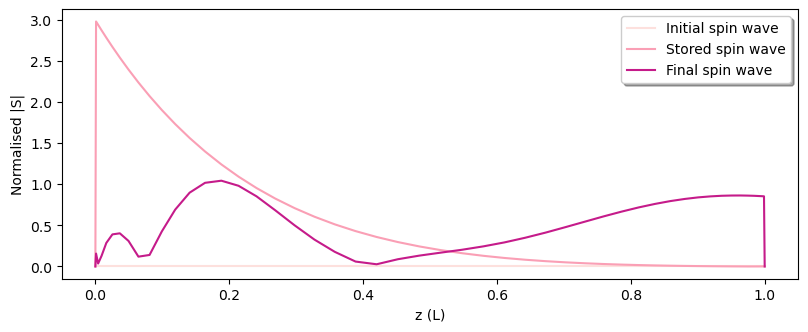

In [15]:
photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega_store), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_tp[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text(tau*1e9, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-tau)*1e9, 3, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-tau)*1e9, 1, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol.zCheby, np.abs(sol.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

In [16]:
beam_radius = 100e-6

print(f"Storage control max power = {atom.rabi_frequency_to_power(Omega_store, r=beam_radius)*1000: .0f} mW")
print(f"Retrieval control max power = {atom.rabi_frequency_to_power(Omega_retrieve, r=beam_radius)*1000: .0f} mW")

Storage control max power =  64 mW
Retrieval control max power =  257 mW


### Optimise

In [21]:
### Make solver class
m = 800

t0 = 3*tau
tend = 4*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 5e9)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 1e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 10

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

KeyboardInterrupt: 

In [18]:
beam_radius = 100e-6

print(f"Optimised storage control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[0][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised storage control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[0][:, 0])), r=beam_radius)*1000: .0f} mW")

print(f"Optimised retrieval control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[1][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised retrieval control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[1][:, 0])), r=beam_radius)*1000: .0f} mW")

Optimised storage control max rabi frequency (2π × GHz) =  2 
Optimised storage control max power =  284 mW
Optimised retrieval control max rabi frequency (2π × GHz) =  2 
Optimised retrieval control max power =  268 mW


## OD = 100 (standard OD = 200)

### Test control initial condition 

In [22]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n": 6, "L":0, "F" : 3}}}
atom = A.Cs(config)

In [23]:
T = 0 # temperature of the ensemble in K
vno = 1 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = 100

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

In [24]:
### Make solver class
protocol = 'EIT'
tau = 330e-12*np.sqrt(2)
m = 800
detuning = 0

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 4*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

tr = 2*t0 # storage time

Omega_store = 7e9
Omega_retrieve = 1e10
Control_tp = (S.gaussian(t, t0, tau, Omega_store) + S.gaussian(t, t0+tr, tau, Omega_retrieve))[:, None] * control_pol[None, :] # control field

Control_tzp = sol.co_prop( Control_tp )
sol.solve(Control_tzp, method='RK4-Ralston')

storage = sol.storage_efficiency(sol.S, mi=m//2) # half way through simulation
retrieved = sol.retrieval_efficiency(sol.E, m//2, 0)

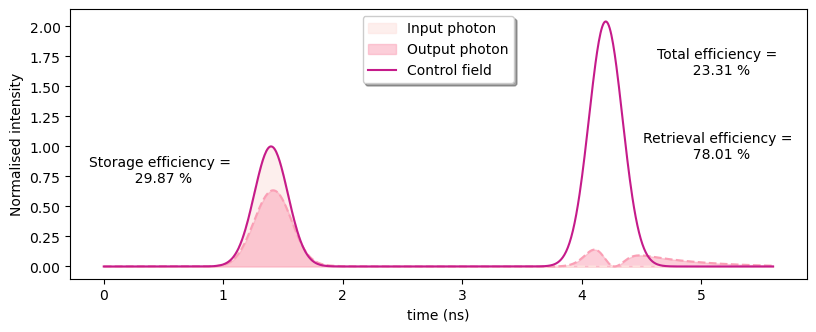

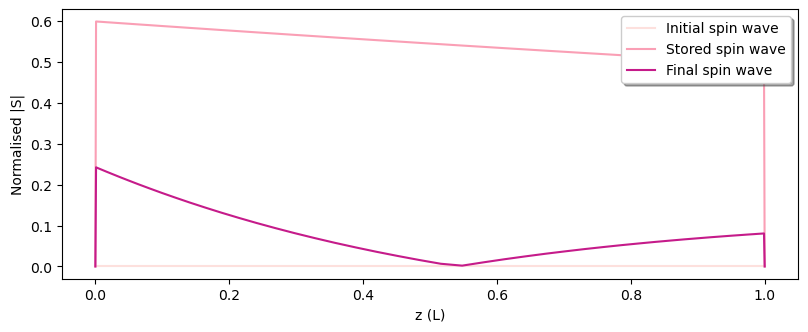

In [27]:
photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega_store), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_tp[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text(tau*1e9, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-tau)*1e9, 1.7, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text((tend-tau)*1e9, 1, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol.zCheby, np.abs(sol.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

In [28]:
beam_radius = 100e-6

print(f"Storage control max power = {atom.rabi_frequency_to_power(Omega_store, r=beam_radius)*1000: .0f} mW")
print(f"Retrieval control max power = {atom.rabi_frequency_to_power(Omega_retrieve, r=beam_radius)*1000: .0f} mW")

Storage control max power =  126 mW
Retrieval control max power =  257 mW


### Optimise

In [30]:
### Make solver class
m = 800

t0 = 3*tau
tend = 4*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 7e9)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 1e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 10

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=100, total_eff=0.44119032449235474

Max amps: readin=3472458665.6145134, readout=10009653719.746222

Total energy: readin=9.070102943567591e-11, readout=5.696064347840162e-10



In [ ]:
beam_radius = 100e-6

print(f"Optimised storage control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[0][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised storage control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[0][:, 0])), r=beam_radius)*1000: .0f} mW")

print(f"Optimised retrieval control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[1][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised retrieval control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[1][:, 0])), r=beam_radius)*1000: .0f} mW")

Optimised storage control max rabi frequency (2π × GHz) =  5 
Optimised storage control max power =  2507 mW
Optimised retrieval control max rabi frequency (2π × GHz) =  22 
Optimised retrieval control max power =  48942 mW


# EEVI-EIT

## OD = 1500 (standard OD = 3000)

### Test control initial condition 

In [3]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n": 6, "L":0, "F" : 3}}}
atom = A.Cs(config)

In [12]:
### Define solver parameters

T = 0 # temperature of the ensemble in K
vno = 1 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = 1500

n = 50 # number of space steps. Note these are not evenly spaced.

protocol = 'EIT'
tau = 330e-12*np.sqrt(2)
m = 800
detuning = 0

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
control_pol = np.array([1, 0]) #should be normalised

Omega_W1 = 3e9
Omega_W2 = 3e9
Omega_R1 = 3e9
Omega_R2 = 3e9

phase = 0
eta_loop = 1

In [13]:
### W1

Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 
Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

sol_W1 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tp = (S.gaussian(t, t0, tau, Omega_W1))[:, None] * control_pol[None, :] # control field

Control_tzp = sol_W1.co_prop( Control_tp )
sol_W1.solve(Control_tzp, method='RK4-Ralston')

storage_W1 = sol_W1.storage_efficiency(sol_W1.S, mi=-1) # normal storage efficiency
retrieved_W1 = sol_W1.retrieval_efficiency(sol_W1.E, 0, 0) # leaked efficiency

print(f"Normal storage efficiency = {storage_W1*100: .2f} %")
print(f"Normal leaked efficiency = {retrieved_W1*100: .2f} %")
print()

### W2

Einits = sol_W1.E[:, -1]*np.sqrt(sol_W1.gamma)*np.exp(1j*phase)*np.sqrt(eta_loop)
Sinits = sol_W1.S[-1]

sol_W2 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tp = (S.gaussian(t, t0, tau, Omega_W2))[:, None] * control_pol[None, :] # control field

Control_tzp = sol_W2.co_prop( Control_tp )
sol_W2.solve(Control_tzp, method='RK4-Ralston')

storage_W2 = sol_W2.storage_efficiency(sol_W2.S, mi=-1) # EEVI enhanced storage efficiency
retrieved_W2 = sol_W2.retrieval_efficiency(sol_W2.E, 0, 0) # final leaked efficiency

print(f"EEVI enhanced storage efficiency = {storage_W2*100: .2f} %")
print(f"EEVI leaked efficiency = {retrieved_W2*100: .2f} %")
print()

### R1

Einits = np.zeros(m)[:, None] * photon_pol[None, :] 
Sinits = sol_W2.S[-1] # initial spin wave

sol_R1 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tp = (S.gaussian(t, t0, tau, Omega_R1))[:, None] * control_pol[None, :] # control field

Control_tzp = sol_R1.co_prop( Control_tp )
sol_R1.solve(Control_tzp, method='RK4-Ralston')

storage_R1 = sol_R1.storage_efficiency(sol_R1.S, mi=-1) # remaining spin wave efficiency
retrieved_R1 = sol_R1.retrieval_efficiency(sol_R1.E, 0, 0) # normal retrieval efficiency

print(f"Remaining spin wave = {storage_R1*100: .2f} %")
print(f"Normal retrieval efficiency = {retrieved_R1*100: .2f} %")
print()

### R2

Einits = sol_R1.E[:, -1]*np.sqrt(sol_R1.gamma)*np.exp(1j*phase)*np.sqrt(eta_loop)
Sinits = sol_R1.S[-1] # initial spin wave

sol_R2 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

Control_tp = (S.gaussian(t, t0, tau, Omega_R2))[:, None] * control_pol[None, :] # control field

Control_tzp = sol_R2.co_prop( Control_tp )
sol_R2.solve(Control_tzp, method='RK4-Ralston')

storage_R2 = sol_R2.storage_efficiency(sol_R2.S, mi=-1) # final remaining spin wave efficiency
retrieved_R2 = sol_R2.retrieval_efficiency(sol_R2.E, 0, 0) # EEVI enhanced retrieval efficiency

print(f"Final remaining spin wave = {storage_R2*100: .2f} %")
print(f"EEVI enhanced retrieval efficiency = {retrieved_R2*100: .2f} %")

Normal storage efficiency =  57.19 %
Normal leaked efficiency =  8.50 %

EEVI enhanced storage efficiency =  27.66 %
EEVI leaked efficiency =  13.15 %

Remaining spin wave =  21.64 %
Normal retrieval efficiency =  2.66 %

Final remaining spin wave =  17.55 %
EEVI enhanced retrieval efficiency =  3.21 %


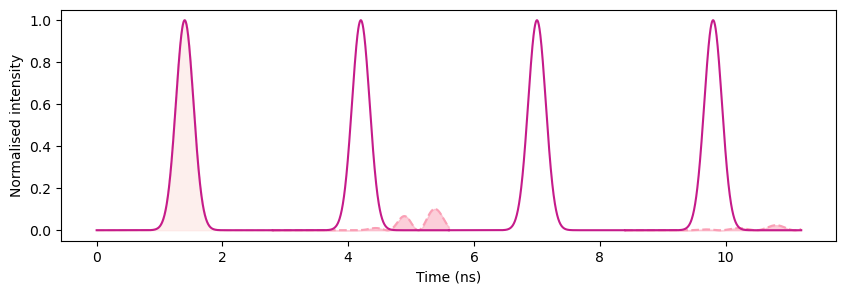

In [14]:
photon_norm = max(pow(np.abs(sol_W1.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega_W1), 2) # normalise factor for plotting control field

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 3))

# Plotting the amplitude on the left y-axis
# Write 1 
ax1.plot(t*1e9, np.abs(sol_W1.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', linestyle='dashed')
ax1.fill_between(t*1e9, np.abs(sol_W1.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax1.plot(t*1e9, np.abs(S.gaussian(t, t0, tau, Omega_W1))**2 /control_norm, label='W1',  color='#c51b8aff')
# Write 2
ax1.plot((tend+t)*1e9, np.abs(sol_W2.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax1.fill_between((tend+t)*1e9, np.abs(sol_W2.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax1.plot((tend+t)*1e9, np.abs(S.gaussian(t, t0, tau, Omega_W2))**2 /control_norm, label='W2',  color='#c51b8aff')
# Read 1
ax1.plot((2*tend+t)*1e9, np.abs(S.gaussian(t, t0, tau, Omega_R1))**2 /control_norm, label='R1',  color='#c51b8aff')
# Write 2
ax1.plot((3*tend+t)*1e9, np.abs(sol_R2.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax1.fill_between((3*tend+t)*1e9, np.abs(sol_R2.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax1.plot((3*tend+t)*1e9, np.abs(S.gaussian(t, t0, tau, Omega_R2))**2 /control_norm, label='R2',  color='#c51b8aff')
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Normalised intensity', color='k')
ax1.tick_params('y', colors='k')
plt.show()

In [15]:
beam_radius = 100e-6

print(f"W1 max power = {atom.rabi_frequency_to_power(Omega_W1, r=beam_radius)*1000: .0f} mW")
print(f"W2 max power = {atom.rabi_frequency_to_power(Omega_W2, r=beam_radius)*1000: .0f} mW")
print(f"R1 max power = {atom.rabi_frequency_to_power(Omega_R1, r=beam_radius)*1000: .0f} mW")
print(f"R2 max power = {atom.rabi_frequency_to_power(Omega_R2, r=beam_radius)*1000: .0f} mW")

W1 max power =  23 mW
W2 max power =  23 mW
R1 max power =  23 mW
R2 max power =  23 mW


### Optimise

In [17]:
### Make solver class
m = 800

t0 = 3*tau
tend = 8*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 
Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 2e9)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 2e9)[:, None] * control_pol[None, :]
Control_init3 = S.gaussian(t, t0, tau, 2e9)[:, None] * control_pol[None, :]
Control_init4 = S.gaussian(t, t0, tau, 2e9)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2, Control_init3, Control_init4]
step_size = 1

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_opt_MZ_all4, Control_inits, step_size, tol,
                                    adaptive_step_size=True, extra_params=[eta_loop])
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: W1={np.max(np.abs(Control_opts[0][:, 0]))}, W2={np.max(np.abs(Control_opts[1][:, 0]))}, R1={np.max(np.abs(Control_opts[2][:, 0]))}, R2={np.max(np.abs(Control_opts[3][:, 0]))}\n")
print(f"Total energy: W1={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, W2={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}. R1={atom.control_pulse_to_energy(np.abs(Control_opts[2][:, 0]), t, r=250e-6, index=1)}, R2={atom.control_pulse_to_energy(np.abs(Control_opts[3][:, 0]), t, r=250e-6, index=1)}\n")

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=1500, total_eff=0.5889286121796006

Max amps: W1=2788920595.244776, W2=1453770524.4374633, R1=2317220411.9177375, R2=2962565009.7552347

Total energy: W1=5.09467814087943e-11, W2=2.7153176570303104e-11. R1=3.351962501753584e-11, R2=5.83365638748924e-11

